# This Notebook presents the results for the **_dynamic method_**.

### Régularité mensuelle TGV par liaisons

#### https://data.sncf.com/explore/dataset/regularite-mensuelle-tgv-aqst/information/?sort=periode

In [58]:
import pandas
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

fichier="regularite-mensuelle-tgv-aqst.csv"

#df = pandas.read_csv(fichier,sep=";")
df=pandas.read_table(fichier,sep=";")
df=df.sort_values(by=[df.columns[0] , df.columns[1]])

df.head(5)  #  afficher les 5 premières lignes

,Année,Mois,Service,Gare de départ,Gare d'arrivée,Durée moyenne du trajet (min),Nombre de circulations prévues,Nombre de trains annulés,Commentaire (facultatif) annulations,Nombre de trains en retard au départ,...,Retard moyen trains en retard > 15min,Nombre trains en retard > 30min,Nombre trains en retard > 60min,Période,Retard pour causes externes,Retard à cause infrastructure ferroviaire,Retard à cause gestion trafic,Retard à cause matériel roulant,Retard à cause gestion en gare et réutilisation de matériel,Retard à cause prise en compte voyageurs
334,2015,1.0,National,PARIS LYON,NIMES,177.905956,320.0,1.0,NaN,18.0,...,44.045455,12.0,6.0,2015-01,41.935484,19.354839,12.903226,9.677419,12.903226,3.225806
335,2015,1.0,National,PARIS EST,REIMS,47.173709,213.0,0.0,NaN,12.0,...,28.833333,2.0,0.0,2015-01,11.764706,17.647059,23.529412,23.529412,11.764706,11.764706
336,2015,1.0,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,192.349282,210.0,1.0,NaN,3.0,...,54.000000,5.0,4.0,2015-01,14.285714,71.428571,14.285714,0.000000,0.000000,0.000000
337,2015,1.0,National,PARIS MONTPARNASSE,VANNES,200.582386,177.0,1.0,NaN,3.0,...,25.666667,2.0,0.0,2015-01,44.444444,33.333333,11.111111,0.000000,11.111111,0.000000
338,2015,1.0,National,NANTES,STRASBOURG,327.038462,39.0,0.0,NaN,0.0,...,46.666667,3.0,0.0,2015-01,66.666667,0.000000,0.000000,33.333333,0.000000,0.000000


In [59]:
def L1_Lasso(data,start,end,lambda_=1):
    """
    Function the realize a lasso cost estimation of the $\beta$ coefficient $\beta = (\beta_1, \ldots, \beta_n)$.
    
    Params:
    =======
        data (array_like): data used to fit the $\beta$ coefficient.
        start (int): beginning of the segment to estimate
        end (int): end of the segment on which we ake the estimation
        lambda_ (float): constaint for smoother difference between successive $\beta_i$.
        
    Return:
    =======
        The cost value on this segment.
    """
    if data.ndim == 1:
        data.reshape(-1,1)
    if (end - start) < 2:          # threshold to avoid empty segment
        raise 'EmptySegment'
    segment = data[start:end]
    median = np.median(segment,axis=0)
    cost = lambda_*np.sum(np.abs(segment - median))
    return cost

def L2_Ridge(data,start,end,lambda_=1):
    """
    Function the realize a ridge cost estimation of the $\beta$ coefficient $\beta = (\beta_1, \ldots, \beta_n)$.
    
    Params:
    =======
        data (array_like): data used to fit the $\beta$ coefficient.
        start (int): beginning of the segment to estimate
        end (int): end of the segment on which we ake the estimation
        lambda_ (float): constaint for smoother difference between successive $\beta_i$.
        
    Return:
    =======
        The cost value on this segment.
    """
    if data.ndim == 1:
        data.reshape(-1,1)
    if (end - start) < 2:          # threshold to avoid empty segment
        raise 'EmptySegment'
    segment = data[start:end]
    median = np.median(segment,axis=0)
    cost = lambda_*np.sum(np.square(segment - median))
    return cost

In [60]:
from functools import lru_cache

def DynamicProg(data, changepoints,cost=L1_Lasso,lambda_=1, dist_segment=4):
    """
    Find the best subsegment that minimize the cost.
    
    Params:
    =======
        data (array_like): data where we search for change-point.
        dist_segment (int): to create a subsample of data every to $dist_segment$.
        changepoints (int): the number of change-point
        cost (function): which cost function to use
        lambda_ (float): constaint for smoother difference between successive $\beta_i$.
        
    Return:
    =======
        a list of change-point.
    """
    
    def recursive(start, end, changepoints, dist_segment=5):
        dist_seg = dist_segment
        # Cas de base
        if changepoints == 0:

            return {(start,end): cost(data,start,end,lambda_)}

        # recurrence
        else:
            dist_segment_list = [i for i in range(start,end) if i%dist_segment==0]

            changepts = []        #list of possible change-points
            for k in dist_segment_list:
                nbs = k - start
                # check for segment availibility
                if changepoints > (nbs//dist_seg) :
                    continue
                if changepoints * np.ceil(2/dist_seg)*dist_seg + 2 > nbs:
                    continue
                if (end - k) >= 2:
                    changepts.append(k)

            # recursive call on both end : right and left side of the cut
            selected = []
            for i in changepts:
                left_side = recursive(start, i,changepoints-1)
                right_side = recursive(i, end,0)

                tmp = dict(left_side)
                tmp[(i,end)] = right_side[(i,end)]
                selected.append(tmp)
                
            return min(selected,key= lambda d: sum(d.values()))
        
    start = 0
    end = data.shape[0]
    points = recursive(start,end,changepoints)
    return sorted(idx for v, idx in points.keys())

In [61]:
def etat_gare(data,nom):
    """
    Plots results for both column of interest.
    """
    data1 = data['Nombre de circulations prévues'].to_numpy()
    data2 = data['Nombre de trains annulés'].to_numpy()
    result1 = DynamicProg(data1,1,L2_Ridge,lambda_=1,dist_segment=5)
    result2 = DynamicProg(data2,1,L2_Ridge,lambda_=1,dist_segment=5)


    result1.pop() 
    print("k_rupture = ", result1)
    print(nom, " : ",'Nombre de circulations prévues' )
    fig = plt.figure(figsize=(20,7))
    ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)


    ax1.xaxis.set_ticks_position('bottom')
    
    l1 = [k for k in range(result1[0])]
    l2 = [k for k in range(result1[0],data1.shape[0])]

    plt.plot(l1,data1[:result1[0]], color = 'green')
    plt.plot(l2,data1[result1[0]:], color = 'blue')
    for i in result1 :
        plt.axvline(x=i,color='red')

    plt.show()
    
    m1 = np.mean(data1[:result1[0]])
    print(m1)
    m2 = np.mean(data1[result1[0]:])
    print(m2)
    sig = np.std(data1)
    print(sig)

    def normal(x, mu_, sigma_):
        return (1/np.sqrt(2*np.pi*sigma_**2)) * np.exp(-1/2 * (x-mu_)**2/sigma_**2)
    plt.figure(figsize=(10,7))
    x = np.linspace(0,max(data1),10000)
    plt.hist(data1,density=True,bins=30)
    plt.plot(x,normal(x,m1,sig))
    plt.plot(x,normal(x,m2,sig))
    
    result2.pop() 
    print("k_rupture = ", result2)
    print(nom, " : ",'Nombre de circulations prévues' )
    fig = plt.figure(figsize=(20,7))
    ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)


    ax1.xaxis.set_ticks_position('bottom')
    
    l1 = [k for k in range(result2[0])]
    l2 = [k for k in range(result2[0],data2.shape[0])]

    plt.plot(l1,data2[:result2[0]], color = 'green')
    plt.plot(l2,data2[result2[0]:], color = 'blue')
    for i in result2 :
        plt.axvline(x=i,color='red')

    plt.show()
    
    m1 = np.mean(data2[:result2[0]])
    print(m1)
    m2 = np.mean(data2[result2[0]:])
    print(m2)
    sig = np.std(data2)
    print(sig)

    def normal(x, mu_, sigma_):
        return (1/np.sqrt(2*np.pi*sigma_**2)) * np.exp(-1/2 * (x-mu_)**2/sigma_**2)
    plt.figure(figsize=(10,7))
    x = np.linspace(0,max(data2),10000)
    plt.hist(data2,density=True,bins=30)
    plt.plot(x,normal(x,m1,sig))
    plt.plot(x,normal(x,m2,sig))

# With One changing-point

## Paris Lyon

k_rupture =  [30]
PARIS LYON  :  Nombre de circulations prévues


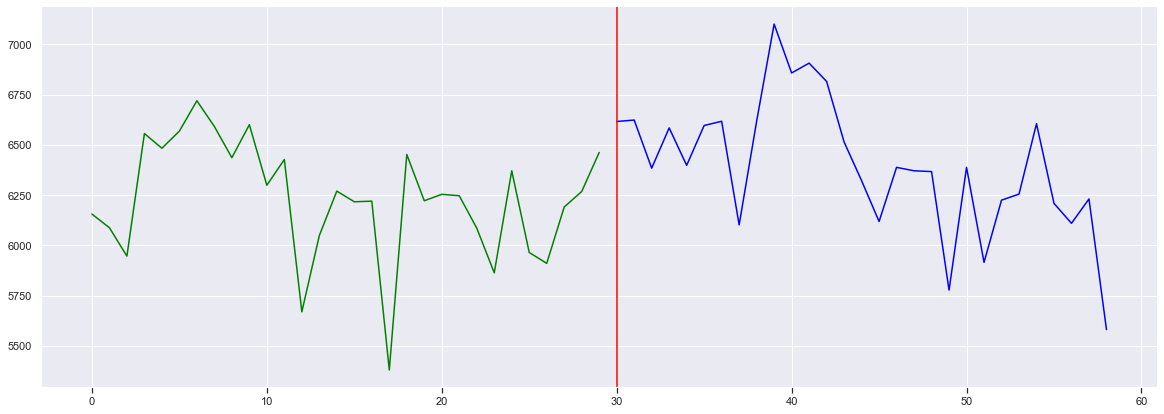

6232.333333333333
6399.827586206897
319.7208851678682
k_rupture =  [35]
PARIS LYON  :  Nombre de circulations prévues


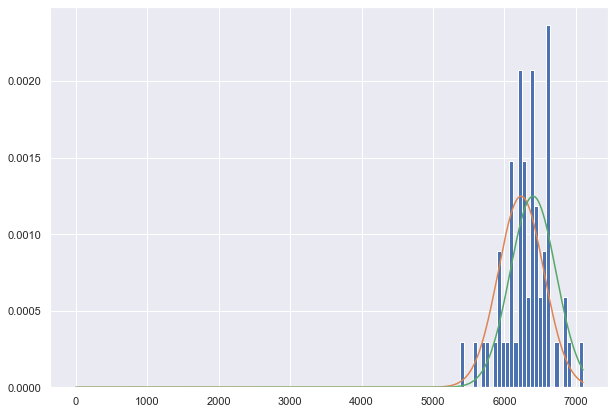

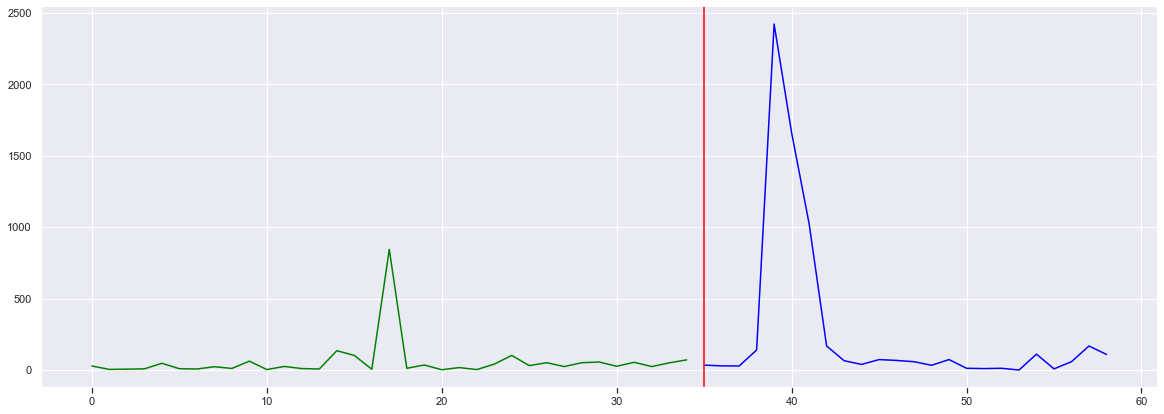

56.74285714285714
266.625
398.8532326280213


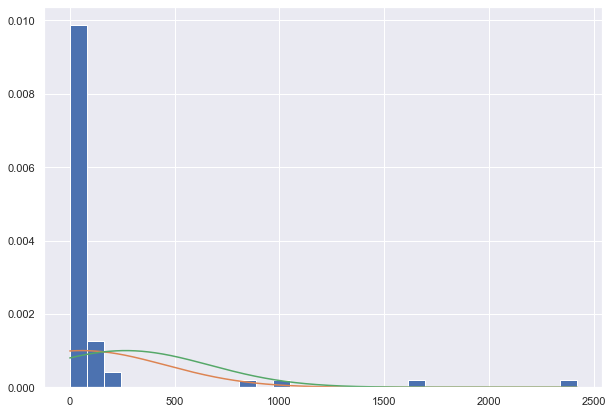

In [62]:
gare=df[df['Gare de départ']=='PARIS LYON']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS LYON')


## Paris Est

k_rupture =  [25]
PARIS EST  :  Nombre de circulations prévues


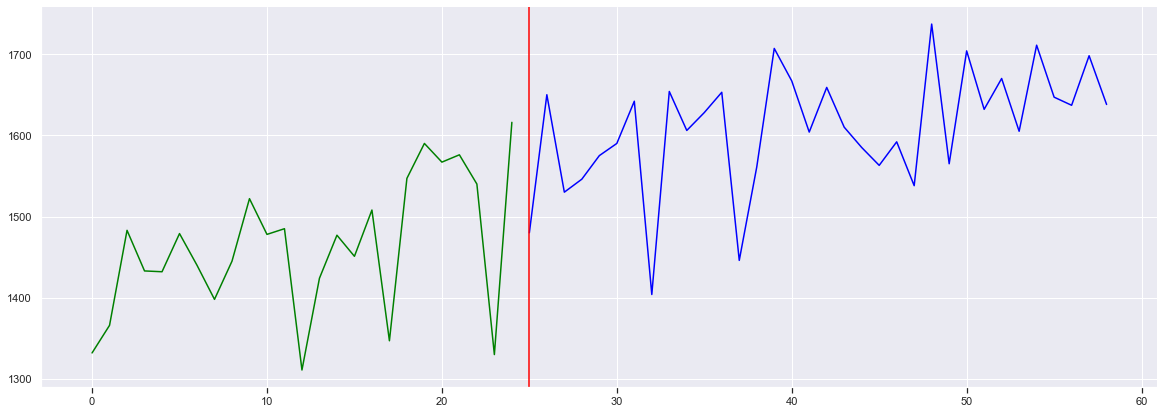

1463.08
1609.8235294117646
106.22118954745686
k_rupture =  [35]
PARIS EST  :  Nombre de circulations prévues


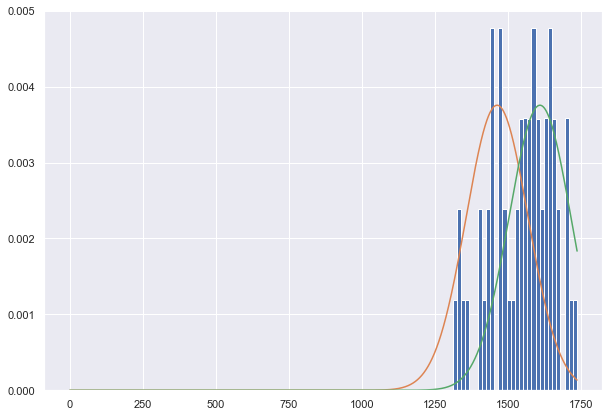

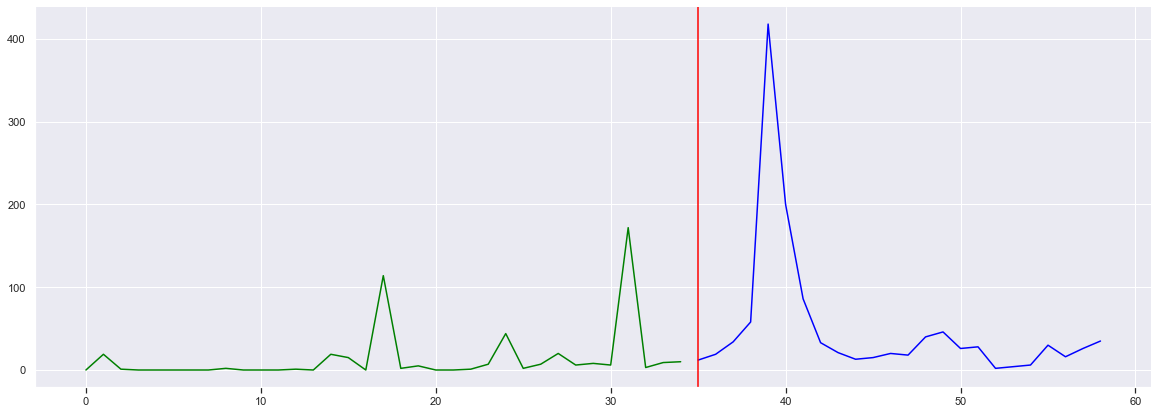

13.514285714285714
50.25
63.32973222902449


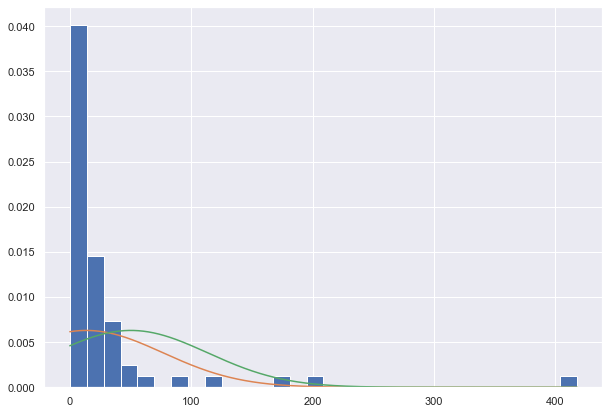

In [63]:
gare=df[df['Gare de départ']=='PARIS EST']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS EST')


## PARIS MONTPARNASSE

k_rupture =  [30]
PARIS MONTPARNASSE  :  Nombre de circulations prévues


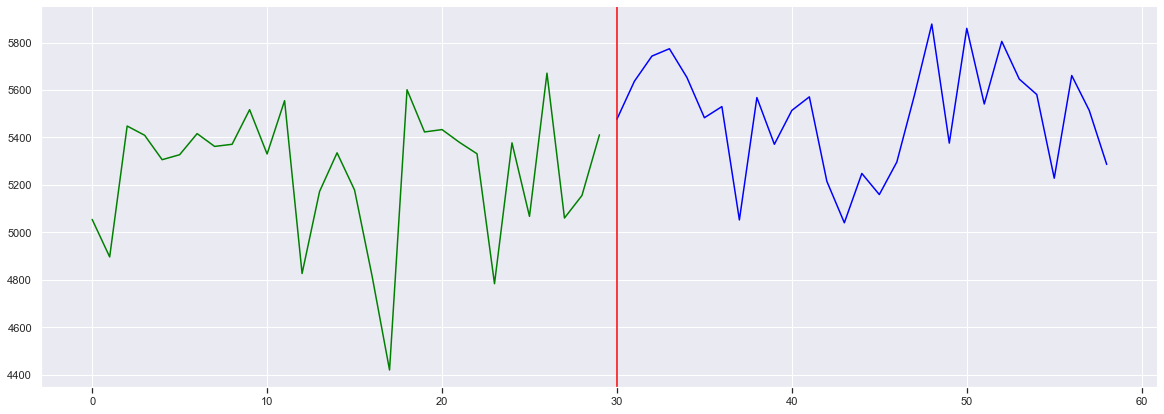

5247.6
5492.517241379311
280.1339565476333
k_rupture =  [35]
PARIS MONTPARNASSE  :  Nombre de circulations prévues


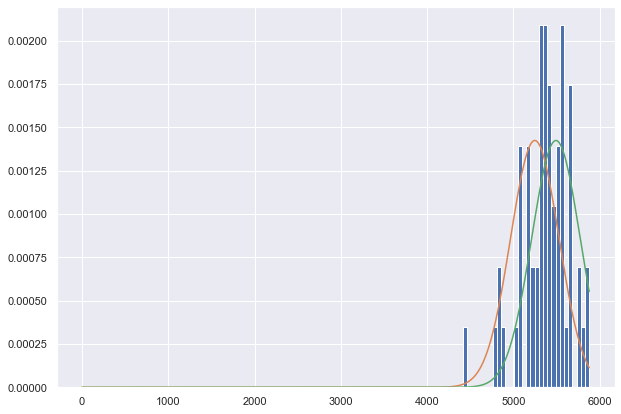

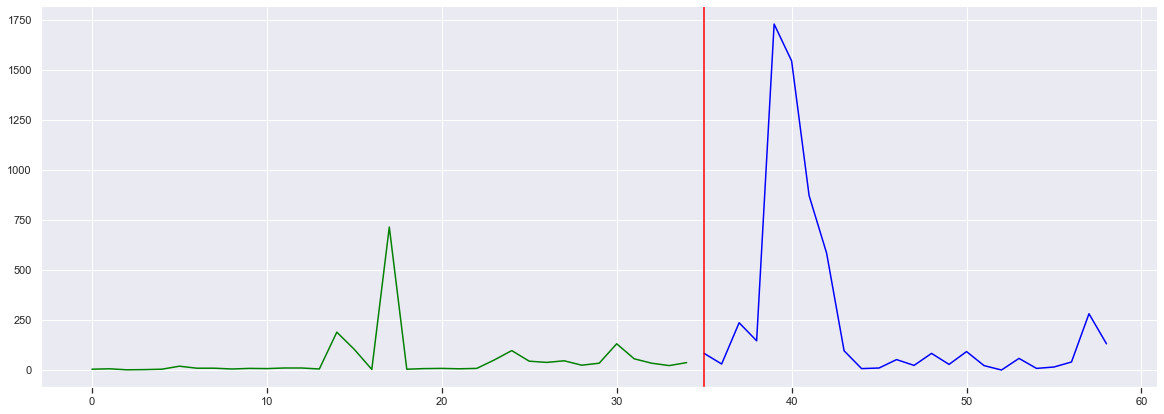

50.114285714285714
257.0
324.7184350343151


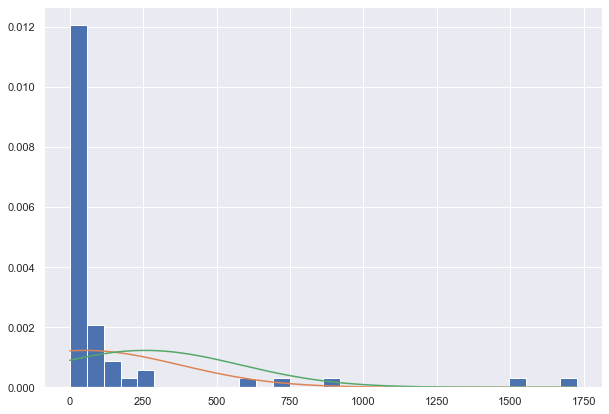

In [64]:
gare=df[df['Gare de départ']=='PARIS MONTPARNASSE']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS MONTPARNASSE')

# LYON PART DIEU 

k_rupture =  [55]
LYON PART DIEU  :  Nombre de circulations prévues


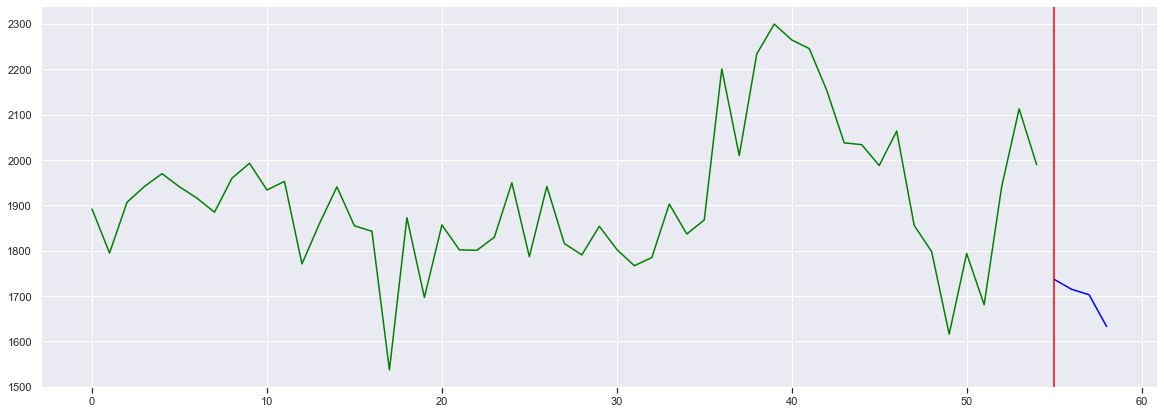

1912.3818181818183
1697.0
158.69938192574634
k_rupture =  [35]
LYON PART DIEU  :  Nombre de circulations prévues


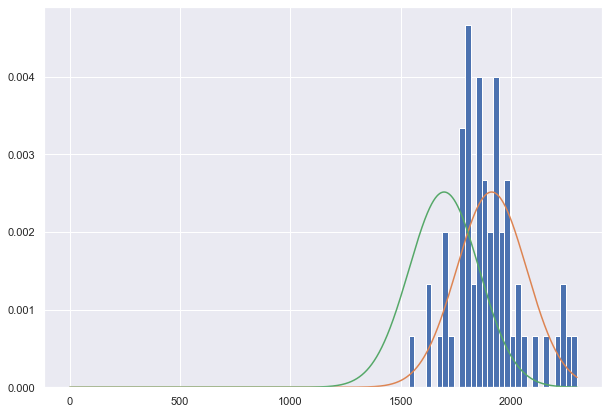

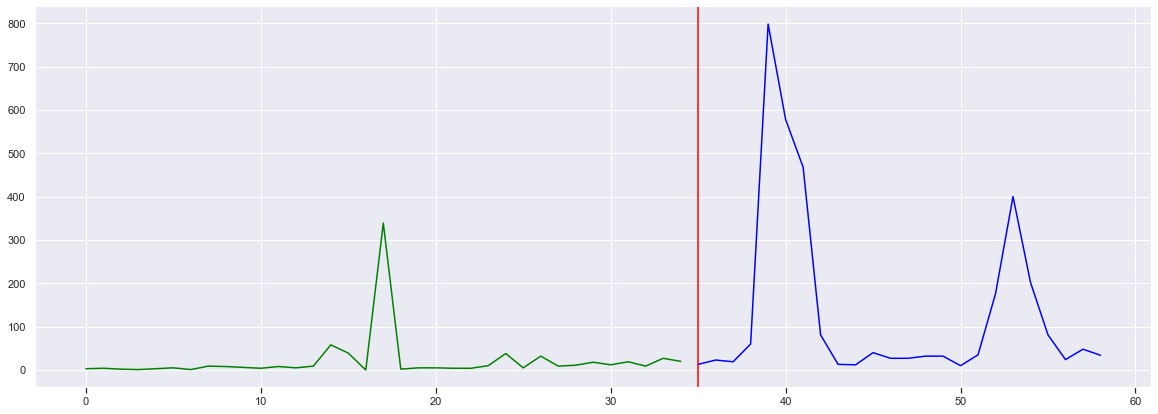

20.97142857142857
134.70833333333334
148.93296626369673


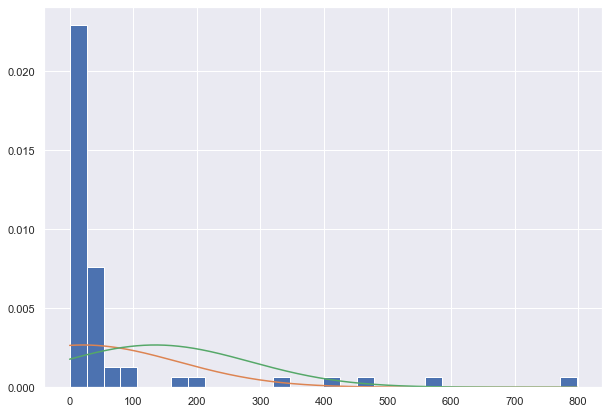

In [65]:
gare=df[df['Gare de départ']=='LYON PART DIEU']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'LYON PART DIEU')

# MARSEILLE ST CHARLES

k_rupture =  [35]
MARSEILLE ST CHARLES  :  Nombre de circulations prévues


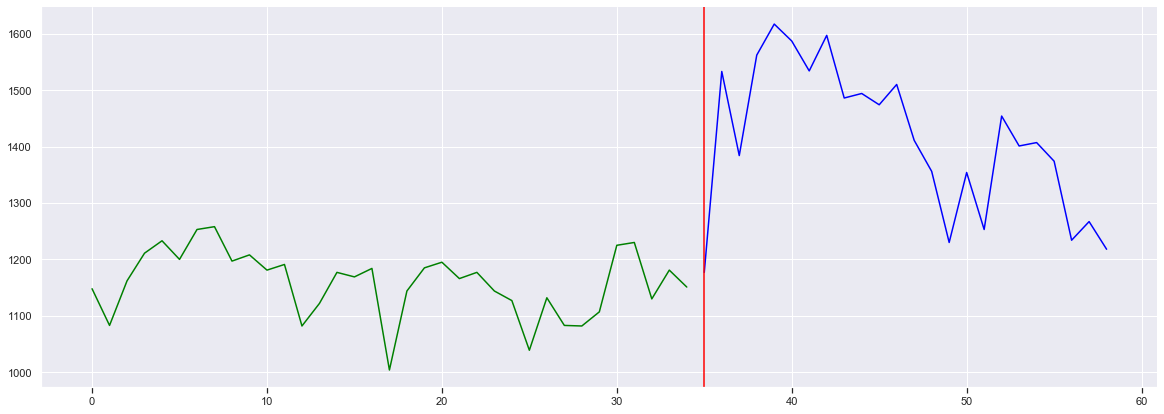

1158.8857142857144
1413.0833333333333
155.97523171992185
k_rupture =  [35]
MARSEILLE ST CHARLES  :  Nombre de circulations prévues


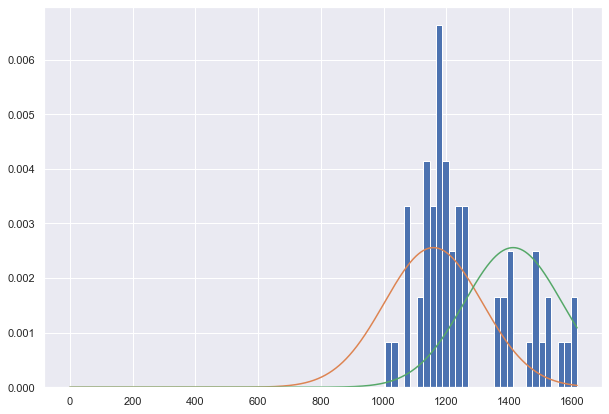

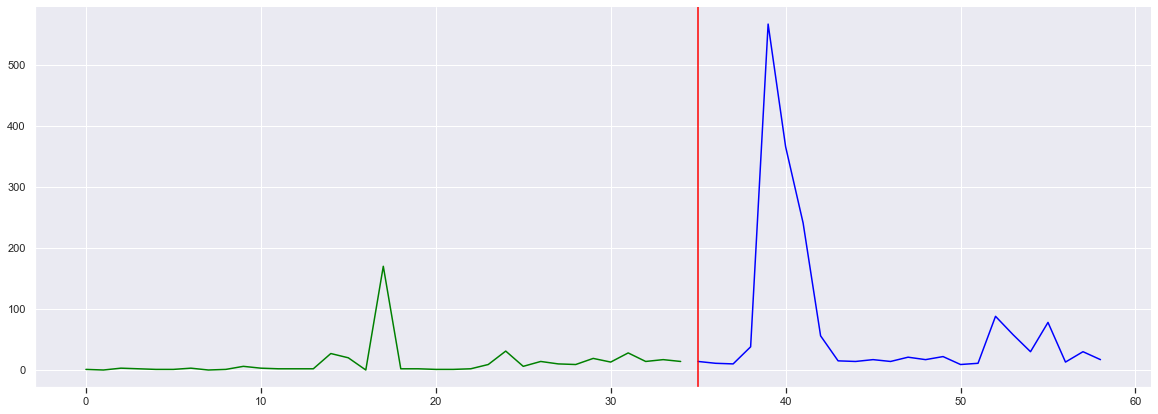

12.457142857142857
73.20833333333333
91.35127814314106


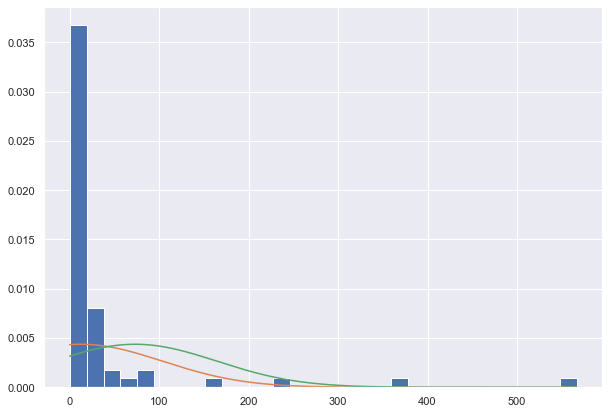

In [66]:
gare=df[df['Gare de départ']=='MARSEILLE ST CHARLES']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'MARSEILLE ST CHARLES')

# PARIS NORD

k_rupture =  [55]
PARIS NORD  :  Nombre de circulations prévues


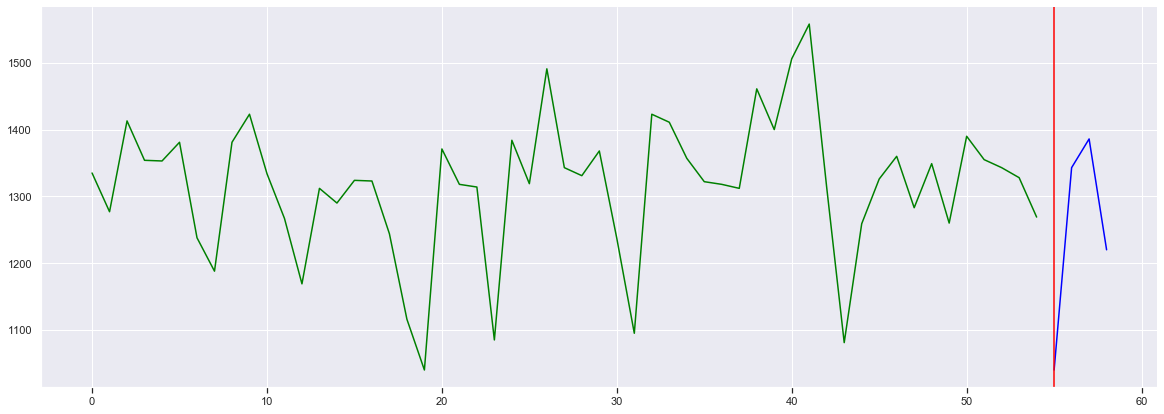

1316.4
1247.25
106.09925810815199
k_rupture =  [35]
PARIS NORD  :  Nombre de circulations prévues


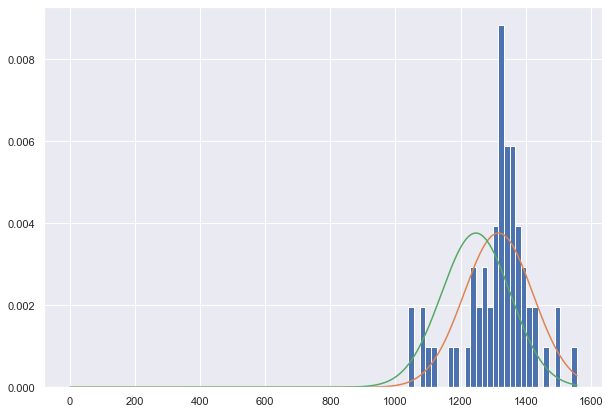

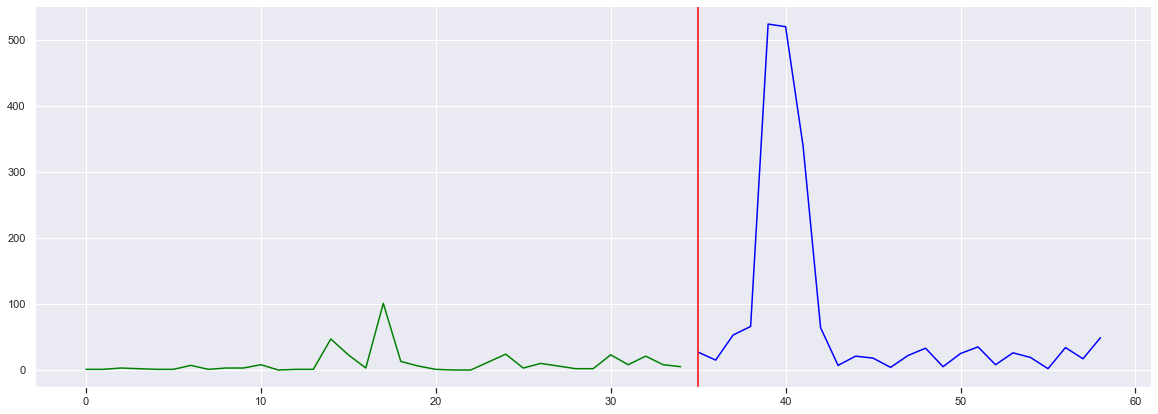

10.028571428571428
80.54166666666667
101.53267001106016


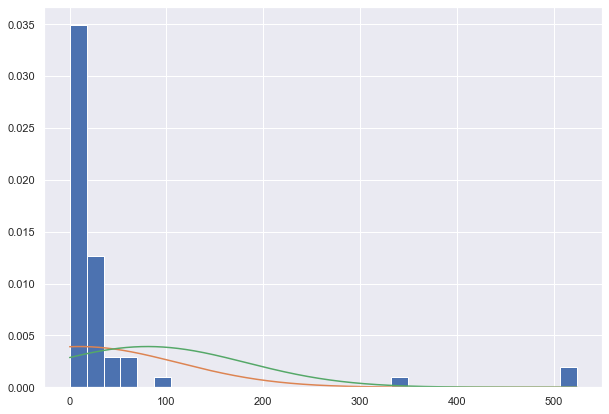

In [67]:
gare=df[df['Gare de départ']=='PARIS NORD']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'PARIS NORD')

# LILLE

k_rupture =  [15]
LILLE  :  Nombre de circulations prévues


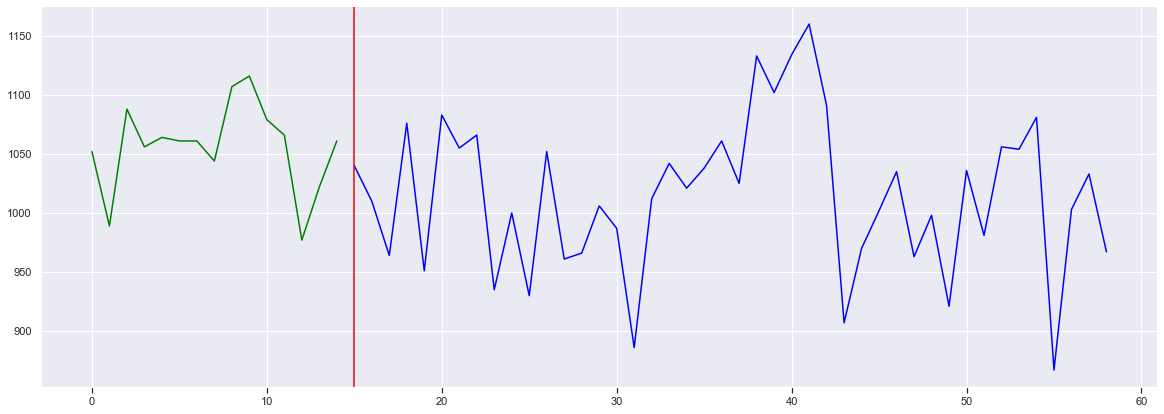

1056.2
1015.0227272727273
61.4558882400051
k_rupture =  [35]
LILLE  :  Nombre de circulations prévues


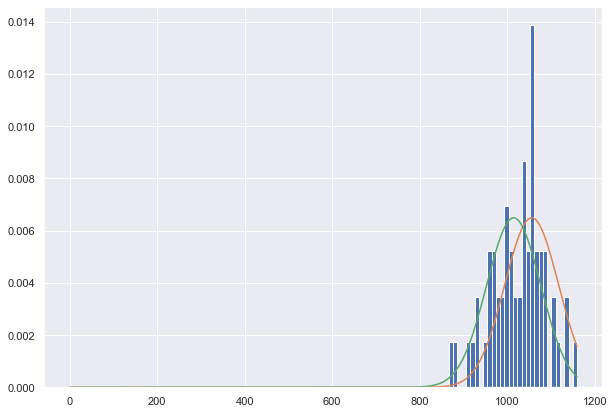

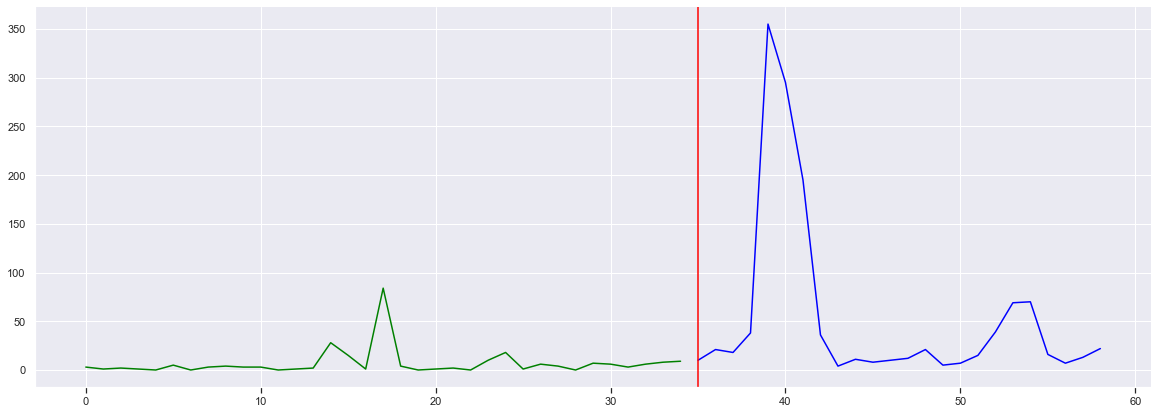

6.885714285714286
54.041666666666664
63.357972598207745


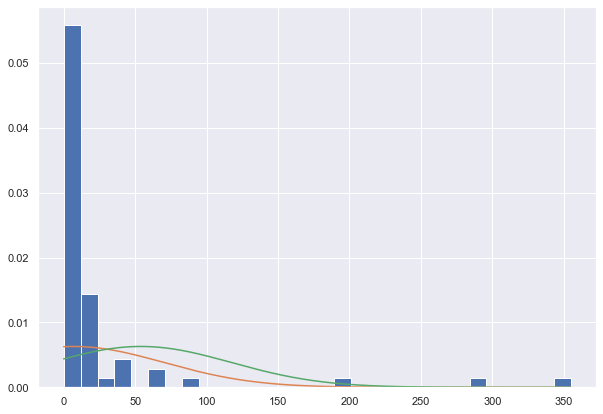

In [68]:
gare=df[df['Gare de départ']=='LILLE']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare(test,'LILLE')

# With Two changing point

In [69]:
def etat_gare_2(data,nom):
    """
    Plots results for both column of interest.
    """
    data1 = data['Nombre de circulations prévues'].to_numpy()
    data2 = data['Nombre de trains annulés'].to_numpy()
    result1 = DynamicProg(data1,2,L2_Ridge,lambda_=1,dist_segment=5)
    result2 = DynamicProg(data2,2,L2_Ridge,lambda_=1,dist_segment=5)


    result1.pop() 
    print("k_rupture = ", result1)
    print(nom, " : ",'Nombre de circulations prévues' )
    fig = plt.figure(figsize=(20,7))
    ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)


    ax1.xaxis.set_ticks_position('bottom')
    
    l1 = [k for k in range(result1[0])]
    l2 = [k for k in range(result1[0],result1[1])]
    l3 = [k for k in range(result1[1],data1.shape[0])]


    plt.plot(l1,data1[:result1[0]], color = 'green')
    plt.plot(l2,data1[result1[0]:result1[1]], color = 'blue')
    plt.plot(l3,data1[result1[1]:], color = 'black')
    for i in result1 :
        plt.axvline(x=i,color='red')

    plt.show()
    
    m1 = np.mean(data1[:result1[0]])
    print(m1)
    m2 = np.mean(data1[result1[0]:result1[1]])
    print(m2)
    m3 = np.mean(data1[result1[1]:])
    print(m3)
    sig = np.std(data1)
    print(sig)

    def normal(x, mu_, sigma_):
        return (1/np.sqrt(2*np.pi*sigma_**2)) * np.exp(-1/2 * (x-mu_)**2/sigma_**2)
    plt.figure(figsize=(10,7))
    x = np.linspace(0,max(data1),10000)
    plt.hist(data1,density=True,bins=30)
    plt.plot(x,normal(x,m1,sig))
    plt.plot(x,normal(x,m2,sig))
    plt.plot(x,normal(x,m3,sig))
    
    result2.pop() 
    print("k_rupture = ", result2)
    print(nom, " : ",'Nombre de circulations prévues' )
    fig = plt.figure(figsize=(20,7))
    ax1 = fig.add_subplot(111)
    # cacher les cadres : haut et droit
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)


    ax1.xaxis.set_ticks_position('bottom')
    
    l1 = [k for k in range(result2[0])]
    l2 = [k for k in range(result2[0],result2[1])]
    l3 = [k for k in range(result2[1],data2.shape[0])]

    plt.plot(l1,data2[:result2[0]], color = 'green')
    plt.plot(l2,data2[result2[0]:result2[1]], color = 'blue')
    plt.plot(l3,data2[result2[1]:], color = 'black')

    for i in result2 :
        plt.axvline(x=i,color='red')

    plt.show()
    
    m1 = np.mean(data2[:result2[0]])
    print(m1)
    m2 = np.mean(data2[result2[0]:result2[1]])
    print(m2)
    m3 = np.mean(data2[result2[1]:])
    print(m3)
    sig = np.std(data2)
    print(sig)

    def normal(x, mu_, sigma_):
        return (1/np.sqrt(2*np.pi*sigma_**2)) * np.exp(-1/2 * (x-mu_)**2/sigma_**2)
    plt.figure(figsize=(10,7))
    x = np.linspace(0,max(data2),10000)
    plt.hist(data2,density=True,bins=30)
    plt.plot(x,normal(x,m1,sig))
    plt.plot(x,normal(x,m2,sig))
    plt.plot(x,normal(x,m3,sig))

## PARIS LYON

k_rupture =  [30, 45]
PARIS LYON  :  Nombre de circulations prévues


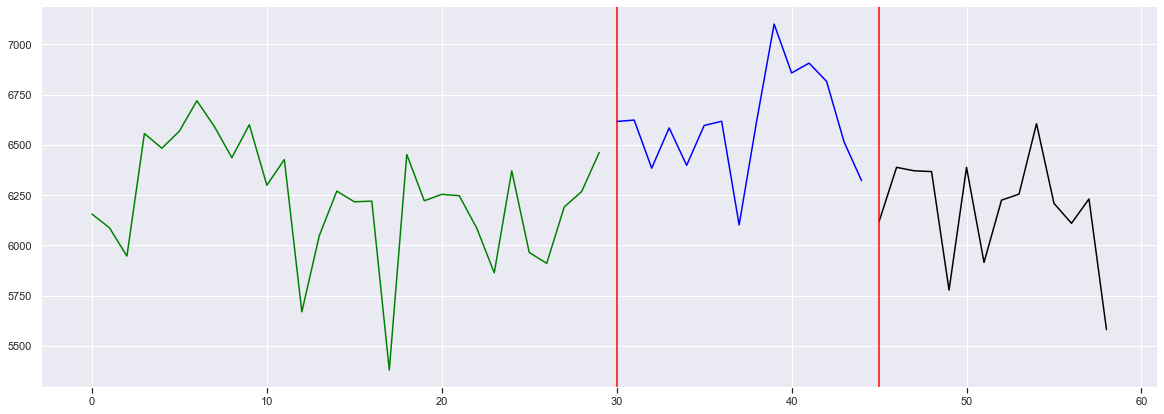

6232.333333333333
6603.4
6181.714285714285
319.7208851678682
k_rupture =  [35, 45]
PARIS LYON  :  Nombre de circulations prévues


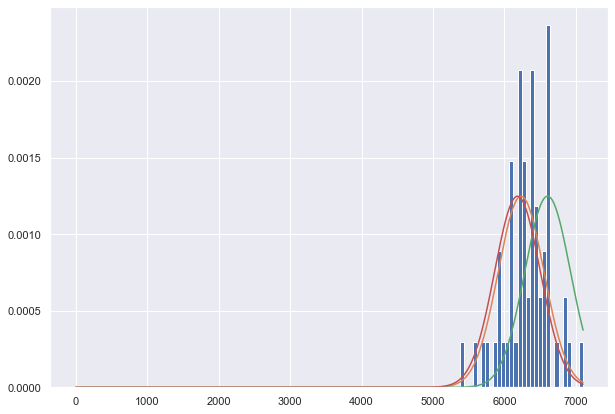

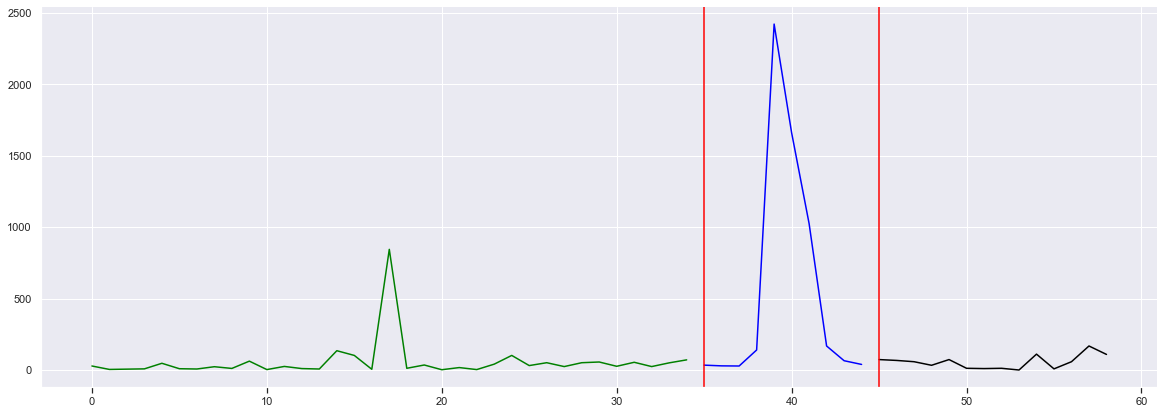

56.74285714285714
560.7
56.57142857142857
398.8532326280213


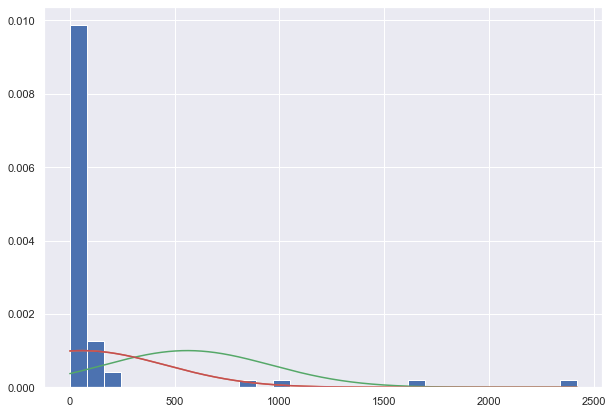

In [70]:
gare=df[df['Gare de départ']=='PARIS LYON']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare_2(test,'PARIS LYON')

# PARIS MONTPARNASSE

k_rupture =  [30, 35]
PARIS MONTPARNASSE  :  Nombre de circulations prévues


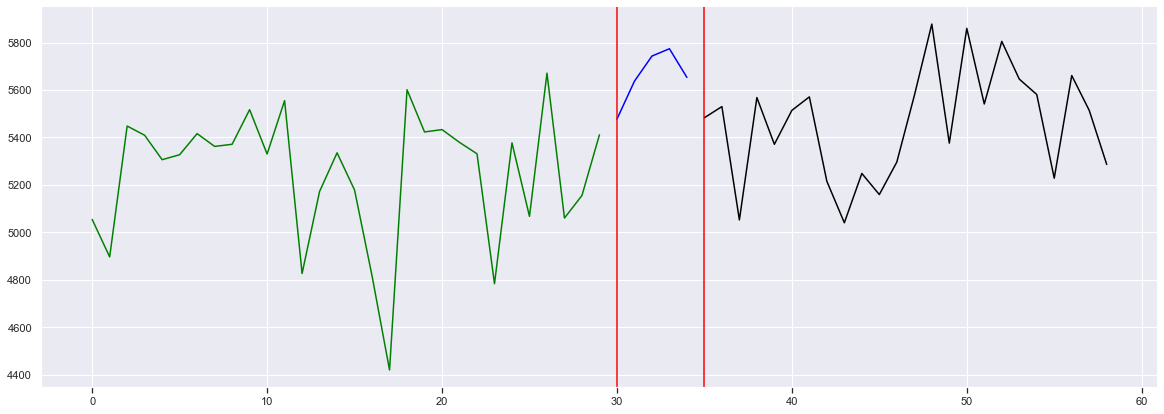

5247.6
5656.8
5458.291666666667
280.1339565476333
k_rupture =  [40, 45]
PARIS MONTPARNASSE  :  Nombre de circulations prévues


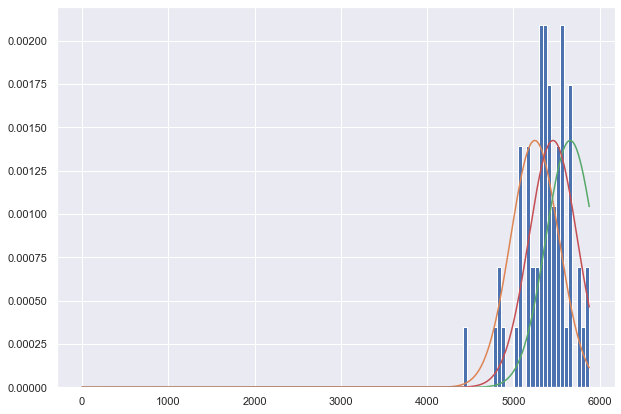

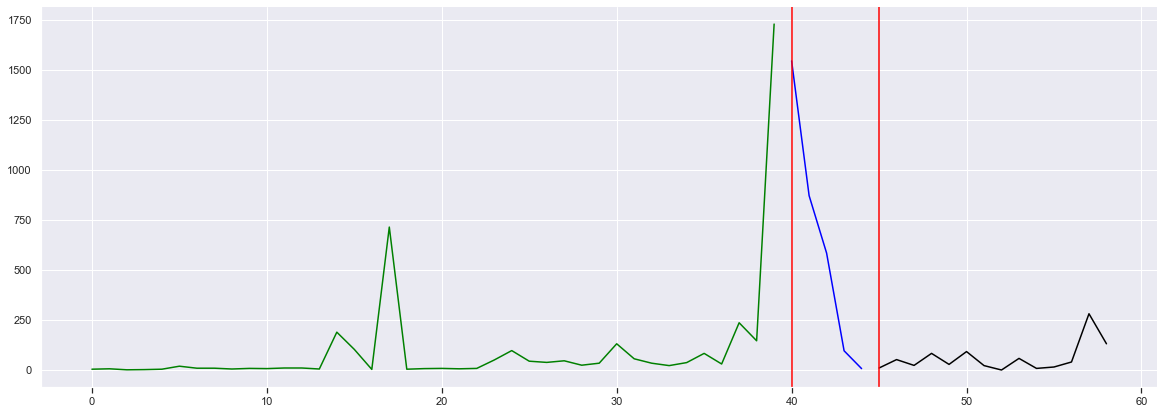

99.425
620.4
60.214285714285715
324.7184350343151


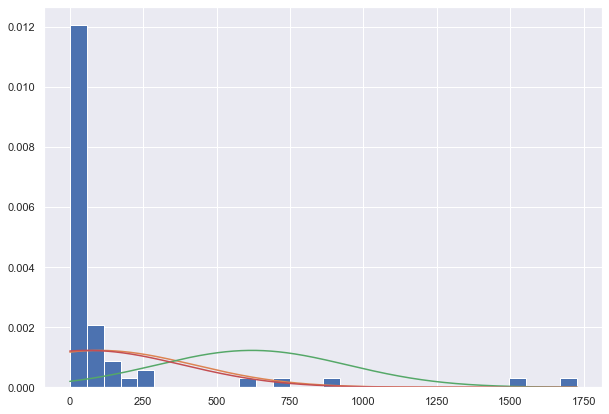

In [71]:
gare=df[df['Gare de départ']=='PARIS MONTPARNASSE']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare_2(test,'PARIS MONTPARNASSE')

# LYON PART DIEU

k_rupture =  [35, 45]
LYON PART DIEU  :  Nombre de circulations prévues


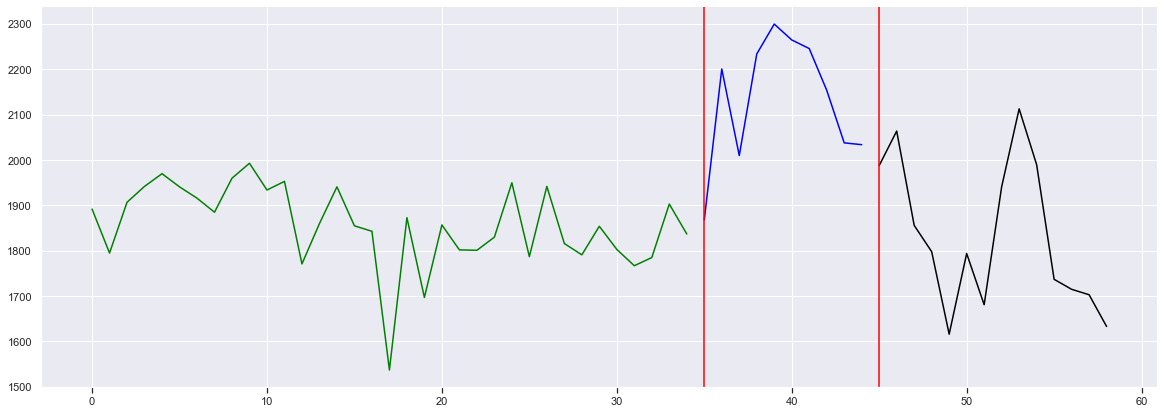

1856.857142857143
2135.0
1830.642857142857
158.69938192574634
k_rupture =  [40, 45]
LYON PART DIEU  :  Nombre de circulations prévues


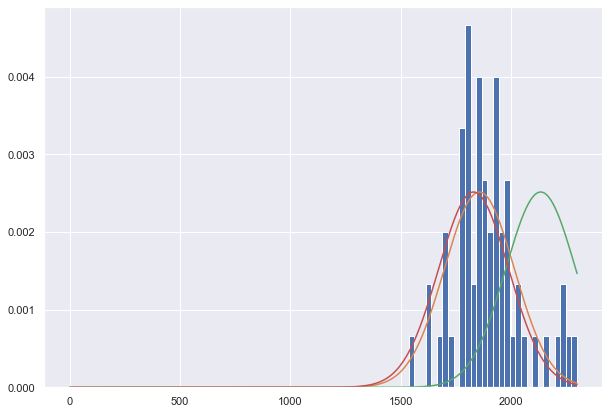

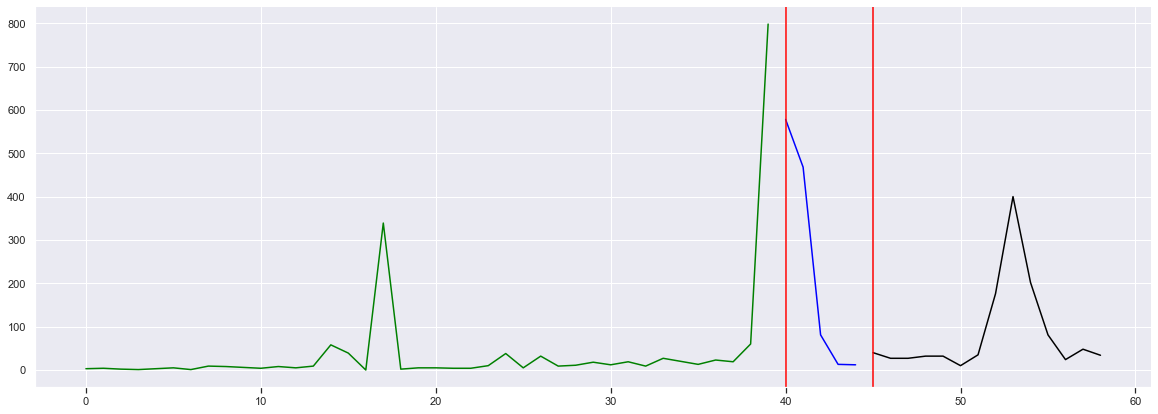

41.175
230.4
83.42857142857143
148.93296626369673


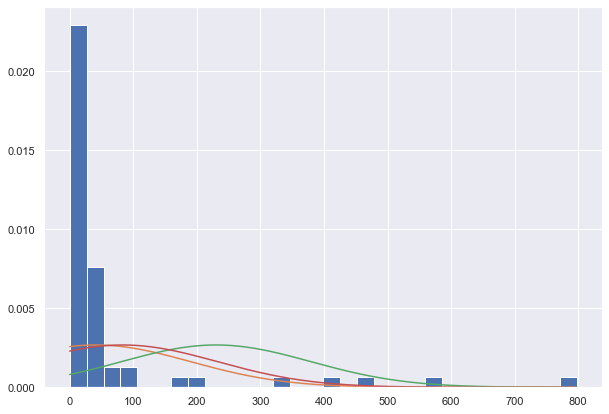

In [72]:
gare=df[df['Gare de départ']=='LYON PART DIEU']
gare=gare.sort_values(by=[gare.columns[0],gare.columns[1]])
gare=gare[['Année','Mois','Gare de départ','Nombre de circulations prévues','Nombre de trains annulés']]
d1 = gare.groupby(['Année','Mois'])['Nombre de trains annulés'].sum().to_numpy()
d2 = gare.groupby(['Année','Mois'])['Nombre de circulations prévues'].sum().to_numpy()

dd=list(zip(d1,d2))

test=pandas.DataFrame(dd,columns=['Nombre de trains annulés','Nombre de circulations prévues'])
test.head()
etat_gare_2(test,'LYON PART DIEU')